# Применение сверточной нейронной сети в задачи восстановления пропущенных значений

Загружаем необходимые библиотеки

In [100]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

import warnings
warnings.filterwarnings("ignore")

Функция загрузки всех необходимых выборок для использования алгоритма.

In [191]:
# Функция, позволяющая искуственно расширять матрицу до нужной размерности
def matrix_expand(matrix, shape = (112, 64)):  
    # Наложим маску и найдем среднее значение по матрице
    masked_array = np.ma.masked_where(matrix == -100.0, matrix)
    mean_value = np.mean(masked_array)
        
    # Создаем матрицу нужной размерности, которая заполнена средним значением исходной матрицы
    new_matrix = np.full(shape, 250)
    # Подставляем исходные значения элементов в матрицу
    new_matrix[:len(matrix), :len(matrix[0])] = matrix[:, :]

    return(new_matrix)

def load_sample(path):
    X_path = os.path.join(path, 'X')
    Y_path = os.path.join(path, 'Y')

    # Список файлов, которые есть в папках
    x_files = os.listdir(X_path)
    y_files = os.listdir(Y_path)
    x_files.sort()
    y_files.sort()

    # Сводим файлы в единый массив - входные матрицы
    X = []
    for i,file in enumerate(x_files):
        matrix = np.load(os.path.join(X_path, file))
        # Расширяем матрицу
        matrix = matrix_expand(matrix)
        # Отсекаем значения, кодирующие пропуск в матрице
        masked_array = np.ma.masked_where(matrix == -100.0, matrix)
        minimum = np.min(masked_array)

        # Замена всех значений -100.0 на минимальное значение на снимке
        matrix[matrix == -100.0] = minimum
        X.append(np.ravel(matrix))
    X = np.array(X)


    shape_X = X.shape
    # Нормализация значений
    X = np.ravel(X)
    X = X.reshape((-1,1))

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Снова складываем все в одномерный массив
    X = np.ravel(X)
    X = X.reshape((shape_X[0], shape_X[1]))

    new_X = []
    for matrix in X:
        matrix = matrix.reshape((112,64))
        new_X.append(matrix)
    new_X = np.array(new_X)

    # Массив - выходные матрицы - то, что мы должны получить на выходе из нейронной сети
    Y = []
    for i,file in enumerate(y_files):
        matrix = np.load(os.path.join(Y_path, file))
        
        # Расширяем матрицу
        matrix = matrix_expand(matrix)
        
        # Раскладываем матрицу в одномерный массив
        q = np.ravel(matrix)
        Y.append(q)
    Y = np.array(Y)

    shape_Y = Y.shape
    # Нормализация значений
    Y = np.ravel(Y)
    Y = Y.reshape((-1, 1))

    Y = scaler.transform(Y)

    # Снова складываем все в одномерный массив
    Y = np.ravel(Y)
    Y = Y.reshape((shape_Y[0], shape_Y[1]))
    
    new_Y = []
    for matrix in Y:
        matrix = matrix.reshape((112,64))
        new_Y.append(matrix)
    new_Y = np.array(new_Y)

    # Разделение выборки на обучение и тест
    X_train = new_X[:350,:,:]
    X_test = new_X[350:, :, :]

    Y_train = new_Y[:350, :]
    Y_test = new_Y[350:, :]
    
    # Нарисуем некоторые из матриц для того, чтобы убедиться, праивльно ли мы все сделали
    first_matrix = X_test[5]
    masked_array = np.ma.masked_where(first_matrix == np.min(first_matrix), first_matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='#F4F4F4')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 0.3, vmax = 0.5)
    plt.colorbar()
    plt.title('Матрица X - предиктор (нормализованная)')
    plt.show()

    first_matrix = Y_test[5]
    masked_array = np.ma.masked_where(first_matrix == 0, first_matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='#F4F4F4')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 0.3, vmax = 0.5)
    plt.colorbar()
    plt.title('Матрица Y - отклик (нормализованная)')
    plt.show()

    # В явном виде задаем размерность данных
    X_train = X_train.reshape(350, 112, 64, 1)
    X_test = X_test.reshape(53, 112, 64, 1)
    Y_train = Y_train.reshape(350, 112, 64, 1)
    Y_test = Y_test.reshape(53, 112, 64, 1)

    print('Размерность предикторов в обучающей выборке -', X_train.shape)
    print('Размерность отклика в обучающей выборке -', Y_train.shape)
    return(X_train, X_test, Y_train, Y_test)

Загрузим выборку, заранее разделим её на обучение и тест.

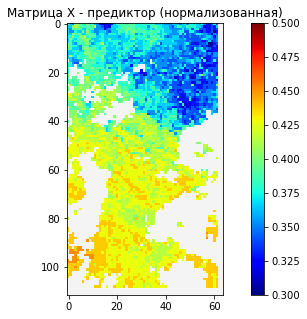

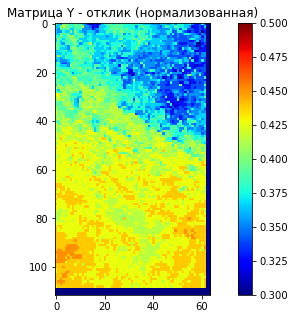

Размерность предикторов в обучающей выборке - (350, 112, 64, 1)
Размерность отклика в обучающей выборке - (350, 112, 64, 1)


In [192]:
# Обучающая выборка + тест
X_train, X_test, y_train, y_test = load_sample(path = '/media/mikhail/Data/Neural_train/Train_data')

## Нейронная сеть архитектуры Convolutional autoencoder

Определяем архитектуру нейросети

In [223]:
#### from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Reshape
from keras.models import Model
from keras import backend as K

# На вход автоэнкодеру подаются данные следующей размерности
input_img = Input(shape=(112,64,1))

# Будем использовать небольшое количесство фильтров 
x = Conv2D(7, (4, 4), activation='relu', padding = 'same', kernel_initializer='he_normal')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(5, (4, 4), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
x = MaxPooling2D((4, 4), padding='same')(x)
encoded = Conv2D(1, (4, 4), activation='relu', padding='same')(x)

# Мы дважды провернули операцию пулинга на картах окном 2 на 2
# На этом моменте представление (14, 8, 1)

input_encoded = Input(shape=(14, 8, 1))
x = Conv2D(5, (4, 4), activation='relu', padding='same', kernel_initializer='he_normal')(input_encoded)
x = UpSampling2D((2, 2), interpolation='bilinear')(x)
x = Conv2D(7, (4, 4), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
x = Dropout(0.3)(x)
x = UpSampling2D((4, 4), interpolation='bilinear')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x) 

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.compile(loss = 'mae', optimizer = 'adadelta', metrics = ['mse', 'mae'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       (None, 112, 64, 1)        0         
_________________________________________________________________
encoder (Model)              (None, 14, 8, 1)          765       
_________________________________________________________________
decoder (Model)              (None, 112, 64, 1)        660       
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [224]:
# Обучение на 20 эпох 
hist = autoencoder.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50)

Train on 350 samples, validate on 53 samples
Epoch 1/50
350/350 [==============================] - 3s 8ms/step - loss: 0.1939 - mse: 0.0555 - mae: 0.1939 - val_loss: 0.1920 - val_mse: 0.0486 - val_mae: 0.1920
Epoch 2/50
350/350 [==============================] - 1s 3ms/step - loss: 0.1559 - mse: 0.0362 - mae: 0.1559 - val_loss: 0.1767 - val_mse: 0.0412 - val_mae: 0.1767
Epoch 3/50
350/350 [==============================] - 1s 3ms/step - loss: 0.1520 - mse: 0.0343 - mae: 0.1520 - val_loss: 0.1825 - val_mse: 0.0427 - val_mae: 0.1825
Epoch 4/50
350/350 [==============================] - 1s 3ms/step - loss: 0.1481 - mse: 0.0324 - mae: 0.1481 - val_loss: 0.1540 - val_mse: 0.0316 - val_mae: 0.1540
Epoch 5/50
350/350 [==============================] - 1s 3ms/step - loss: 0.1429 - mse: 0.0302 - mae: 0.1429 - val_loss: 0.1886 - val_mse: 0.0435 - val_mae: 0.1886
Epoch 6/50
350/350 [==============================] - 1s 3ms/step - loss: 0.1396 - mse: 0.0288 - mae: 0.1396 - val_loss: 0.1633 - val_m

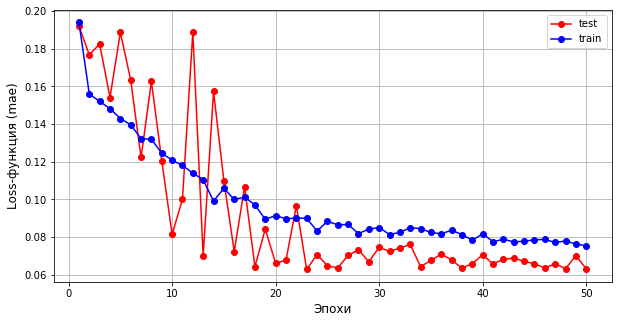

In [225]:
results = hist.history

# Ход обучения сети
res_val_loss = results.get('val_loss')
res_val_mse = results.get('val_mse')
res_val_mae = results.get('val_mae')
res_loss = results.get('loss')
res_mse = results.get('mse')
res_mae = results.get('mae')

# Номер эпохи
epochs = range(1,len(res_val_loss)+1)

# Рисуем график
rcParams['figure.figsize'] = 10, 5
plt.plot(epochs, res_val_loss, '-ok', c = 'red', label = 'test')
plt.plot(epochs, res_loss, '-ok', c = 'blue', label = 'train')
plt.legend(loc = 'best')
plt.ylabel('Loss-функция (mae)', fontsize = 12)
plt.xlabel('Эпохи', fontsize = 12)
plt.grid()
plt.show()

In [226]:
# Для тестовой выборки делаем предсказания
predicted = autoencoder.predict(X_test)
matrix_predicted = np.array(predicted[5])
matrix_predicted = matrix_predicted[:,:,0]
print(matrix_predicted.shape)

(112, 64)


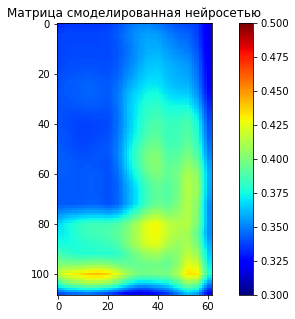

In [227]:
# Матрица, которая была предсказана алгоритмом
matrix_predicted = matrix_predicted[:109,:62]
masked_array = np.ma.masked_where(matrix_predicted == 200.0, matrix_predicted)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(masked_array, interpolation = 'nearest', cmap = cmap, vmin = 0.3, vmax = 0.5)
plt.colorbar()
plt.title('Матрица смоделированная нейросетью')
plt.show()

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

## Старая версия

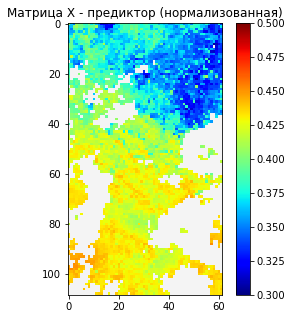

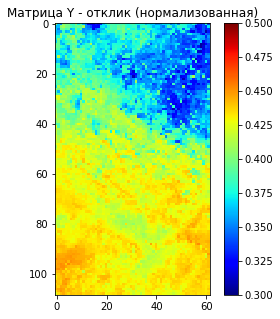

Размерность предикторов в обучающей выборке - (350, 109, 62, 1)
Размерность отклика в обучающей выборке - (350, 6758)


In [13]:
def load_sample(path):
    X_path = os.path.join(path, 'X')
    Y_path = os.path.join(path, 'Y')

    # Список файлов, которые есть в папках
    x_files = os.listdir(X_path)
    y_files = os.listdir(Y_path)
    x_files.sort()
    y_files.sort()

    # Сводим файлы в единый массив - входные матрицы
    X = []
    for i,file in enumerate(x_files):
        matrix = np.load(os.path.join(X_path, file))
        
        # Отсекаем значения, кодирующие пропуск в матрице
        masked_array = np.ma.masked_where(matrix == -100.0, matrix)
        minimum = np.min(masked_array)

        # Замена всех значений -100.0 на минимальное значение на снимке
        matrix[matrix == -100.0] = minimum
        X.append(np.ravel(matrix))
    X = np.array(X)


    shape_X = X.shape
    # Нормализация значений
    X = np.ravel(X)
    X = X.reshape((-1,1))

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Снова складываем все в одномерный массив
    X = np.ravel(X)
    X = X.reshape((shape_X[0], shape_X[1]))

    new_X = []
    for matrix in X:
        matrix = matrix.reshape((109,62))
        new_X.append(matrix)
    new_X = np.array(new_X)

    # Массив - выходные матрицы - то, что мы должны получить на выходе из нейронной сети
    Y = []
    for i,file in enumerate(y_files):
        matrix = np.load(os.path.join(Y_path, file))
        # Раскладываем матрицу в одномерный массив
        q = np.ravel(matrix)
        Y.append(q)
    Y = np.array(Y)

    shape_Y = Y.shape
    # Нормализация значений
    Y = np.ravel(Y)
    Y = Y.reshape((-1, 1))

    Y = scaler.transform(Y)

    # Снова складываем все в одномерный массив
    Y = np.ravel(Y)
    Y = Y.reshape((shape_Y[0], shape_Y[1]))

    # Разделение выборки на обучение и тест
    X_train = new_X[:350,:,:]
    X_test = new_X[350:, :, :]

    Y_train = Y[:350, :]
    Y_test = Y[350:, :]

    first_matrix = X_test[5]
    first_matrix = first_matrix.reshape((109, 62))
    masked_array = np.ma.masked_where(first_matrix == np.min(first_matrix), first_matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='#F4F4F4')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 0.3, vmax = 0.5)
    plt.colorbar()
    plt.title('Матрица X - предиктор (нормализованная)')
    plt.show()

    first_matrix = Y_test[5]
    first_matrix = first_matrix.reshape((109, 62))
    masked_array = np.ma.masked_where(first_matrix == 0, first_matrix)
    cmap = cm.get_cmap('jet')
    cmap.set_bad(color='#F4F4F4')
    plt.imshow(masked_array, interpolation='nearest', cmap=cmap, vmin = 0.3, vmax = 0.5)
    plt.colorbar()
    plt.title('Матрица Y - отклик (нормализованная)')
    plt.show()

    # Заменяем размерность данных
    X_train = X_train.reshape(350, 109, 62, 1)
    X_test = X_test.reshape(53, 109, 62, 1)

    print('Размерность предикторов в обучающей выборке -', X_train.shape)
    print('Размерность отклика в обучающей выборке -', Y_train.shape)
    return(X_train, X_test, Y_train, Y_test)

# Обучающая выборка + тест
X_train, X_test, y_train, y_test = load_sample(path = '/media/mikhail/Data/Neural_train/Train_data')

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPool2D

In [16]:
# Сверточная нейронная сеть
model = Sequential()
# Свертка
model.add(Conv2D(10, 5, 5, activation='relu', kernel_initializer = 'glorot_uniform', input_shape=(109,62,1)))
model.add(MaxPool2D(pool_size = (3,3), strides = (3,3)))
model.add(Conv2D(10, 5, 5, activation='relu', kernel_initializer = 'glorot_uniform', input_shape=(109,62,1)))
model.add(MaxPool2D(pool_size = (5,5), strides = (5,5)))
# Полносвязная часть
model.add(Flatten())
model.add(Dense(50, activation='tanh', kernel_initializer = 'he_normal'))
model.add(Dense(150, activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(Dense(400, activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(Dense(1000, activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(Dense(2000, activation='sigmoid', kernel_initializer = 'he_normal'))
model.add(Dense(5000, activation='sigmoid', kernel_initializer = 'he_normal'))
model.add(Dense(6758, activation='sigmoid'))

In [20]:
# Компилируем модель
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mse', 'mae'])

# Обучение на 100 эпох 
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 200)

Train on 350 samples, validate on 53 samples
Epoch 1/200
350/350 [==============================] - 5s 15ms/step - loss: 0.0870 - mse: 0.0118 - mae: 0.0870 - val_loss: 0.1075 - val_mse: 0.0147 - val_mae: 0.1075
Epoch 2/200
350/350 [==============================] - 5s 14ms/step - loss: 0.0618 - mse: 0.0063 - mae: 0.0618 - val_loss: 0.0722 - val_mse: 0.0090 - val_mae: 0.0722
Epoch 3/200
350/350 [==============================] - 5s 14ms/step - loss: 0.0417 - mse: 0.0033 - mae: 0.0417 - val_loss: 0.0629 - val_mse: 0.0082 - val_mae: 0.0629
Epoch 4/200
350/350 [==============================] - 5s 14ms/step - loss: 0.0368 - mse: 0.0028 - mae: 0.0368 - val_loss: 0.0618 - val_mse: 0.0080 - val_mae: 0.0618
Epoch 5/200
350/350 [==============================] - 5s 15ms/step - loss: 0.0356 - mse: 0.0027 - mae: 0.0356 - val_loss: 0.0586 - val_mse: 0.0078 - val_mae: 0.0586
Epoch 6/200
350/350 [==============================] - 5s 15ms/step - loss: 0.0333 - mse: 0.0026 - mae: 0.0333 - val_loss: 0.

Матрица, которую предсказывает нейронная сеть

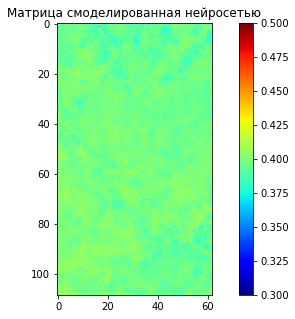

In [21]:
# Для тестовой выборки делаем предсказания
predicted = model.predict(X_test)
predicted = predicted[5]
matrix_predicted = np.array(predicted).reshape((109, 62))

# Матрица, которая была предсказана алгоритмом
masked_array = np.ma.masked_where(matrix_predicted == 200.0, matrix_predicted)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(masked_array, interpolation = 'nearest', cmap = cmap, vmin = 0.3, vmax = 0.5)
plt.colorbar()
plt.title('Матрица смоделированная нейросетью')
plt.show()

Рисуем график обучения нейронной сети

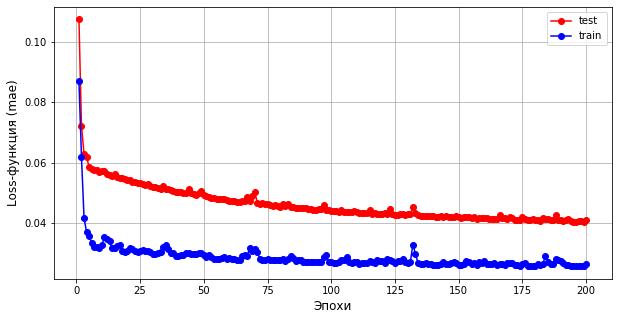

In [22]:
results = hist.history

# Ход обучения сети
res_val_loss = results.get('val_loss')
res_val_mse = results.get('val_mse')
res_val_mae = results.get('val_mae')
res_loss = results.get('loss')
res_mse = results.get('mse')
res_mae = results.get('mae')

# Номер эпохи
epochs = range(1,len(res_val_loss)+1)

# Рисуем график
rcParams['figure.figsize'] = 10, 5
plt.plot(epochs, res_val_loss, '-ok', c = 'red', label = 'test')
plt.plot(epochs, res_loss, '-ok', c = 'blue', label = 'train')
plt.legend(loc = 'best')
plt.ylabel('Loss-функция (mae)', fontsize = 12)
plt.xlabel('Эпохи', fontsize = 12)
plt.grid()
plt.show()